In [1]:
from main import settings_to_fn
import argparse
from omegaconf import OmegaConf
from models import init_model
import sys
import torch
from dataset import NoteTupleDataset
from torch.utils.data import DataLoader
from torch import einsum

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [2]:
# mode = "sin"
mode = "mr"

if mode == "mr":
    config_file = "configs/note_tuple/rel_idx_time_pitch_linear_had_a01.yaml"
elif mode == "sin":
    config_file = "configs/note_tuple/rel_idx_time_pitch_linear_a01_baseline_sin.yaml"

sys.argv = ['argparse_example.py']
parser = argparse.ArgumentParser()
parser.add_argument("--size", type=str, default="small")
parser.add_argument("--debug", action="store_true")
args = parser.parse_args()

In [3]:
cfg_def = OmegaConf.load("configs/small.yaml")
cfg_setting = OmegaConf.load(config_file)
cfg = OmegaConf.merge(cfg_def, cfg_setting)
cfg.data.batch_size = 1
fn = settings_to_fn(cfg, args)

In [4]:
model, _ = init_model(cfg.model, cfg.music_rep, "cpu", False)
model = model.to(device)

Number of trainable parameters: 3700071


In [5]:
layer_idx = 0
p_0_12_4 = torch.zeros((4, 13, 32))
for layer_idx in range(4):
    p_0_12 = torch.zeros((13, 32))

    if mode == "mr":
        Er_octave = model.net.layers[layer_idx].attn.Er_octave.detach()
        Er_semitone = model.net.layers[layer_idx].attn.Er_semitone.detach()
        zeros_for_ignore = torch.zeros((1, 32))
        Er_octave_0 = torch.cat([Er_octave, zeros_for_ignore])
        Er_semitone_0 = torch.cat([Er_semitone, zeros_for_ignore])
        Er_octave_0 = model.net.layers[0].attn.rel_octave_linear(Er_octave_0)
        Er_semitone_0 = model.net.layers[0].attn.rel_semitone_linear(Er_semitone_0)
        Er_octave_semitone = einsum("s d, t d -> s t d", Er_octave_0, Er_semitone_0)
        for i in range(13):
            if i != 12:
                p_0_12[i] = Er_octave_semitone[11, i]
            else:
                p_0_12[i] = Er_octave_semitone[12, 0]
    elif mode == "sin":
        Er_pitch = model.net.layers[layer_idx].attn.Er_pitch.detach()
        # Er_pitch = model.net.layers[0].attn.rel_pitch_linear(Er_pitch)
        for i in range(13):
            p_0_12[i] = Er_pitch[i+127]

    p_0_12_4[layer_idx] = p_0_12


In [6]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

sm_4 = torch.zeros((4, 13, 13))

for i in range(4):
    normalized_p_0_12 = F.normalize(p_0_12_4[i], p=2, dim=1)
    similarity_matrix = torch.matmul(normalized_p_0_12, normalized_p_0_12.T)
    sm_4[i] = similarity_matrix.detach()

In [16]:
p_0_12_4.abs().mean(dim=1)

tensor([[0.2861, 0.2317, 0.0487, 0.0807, 0.0420, 0.2638, 0.2751, 0.1853, 0.0118,
         0.2907, 0.1676, 0.0547, 0.0759, 0.4109, 0.3552, 0.0571, 0.0263, 0.1508,
         0.2247, 0.0728, 0.1477, 0.3233, 0.0371, 0.2225, 0.0021, 0.0804, 0.1950,
         0.0942, 0.2235, 0.1485, 0.1953, 0.3686],
        [0.3473, 0.1675, 0.0315, 0.2173, 0.0633, 0.4025, 0.0120, 0.1807, 0.6702,
         0.0391, 0.1303, 0.0309, 0.8699, 0.0481, 0.4587, 0.0656, 0.1379, 0.1847,
         0.3488, 0.3552, 0.2400, 0.1275, 0.0971, 0.0251, 0.1145, 0.1559, 0.2890,
         0.1549, 0.1875, 0.4003, 0.4839, 0.0704],
        [0.2750, 0.1369, 0.3930, 0.2860, 0.0687, 0.6611, 0.5130, 0.0952, 0.0807,
         0.0706, 0.1482, 0.0457, 0.2355, 0.1030, 0.1123, 0.1436, 0.1205, 0.1283,
         0.4166, 0.3689, 0.0341, 0.3531, 0.2403, 0.1370, 0.3838, 0.4158, 0.1216,
         0.0589, 0.4872, 0.1373, 0.3893, 0.0946],
        [0.3184, 0.2597, 0.0932, 0.1010, 0.0582, 0.1434, 0.3126, 0.2109, 0.3947,
         0.5515, 0.1202, 0.3319, 0.0890,

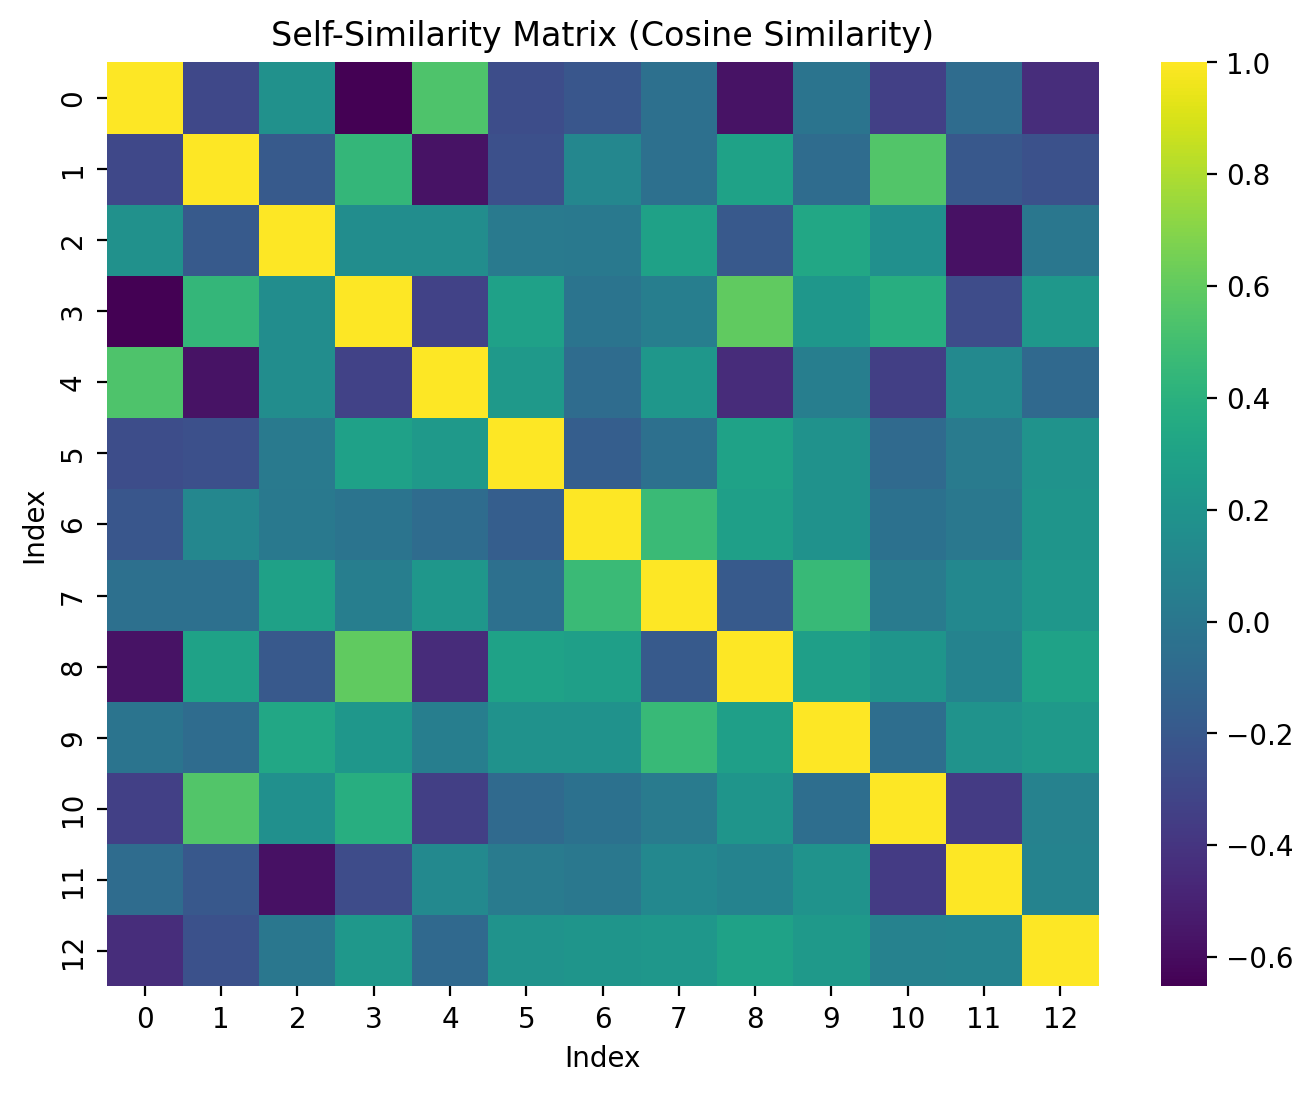

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(sm_4[0].numpy(), cmap='viridis')
plt.title('Self-Similarity Matrix (Cosine Similarity)')
plt.xlabel('Index')
plt.ylabel('Index')
plt.show()

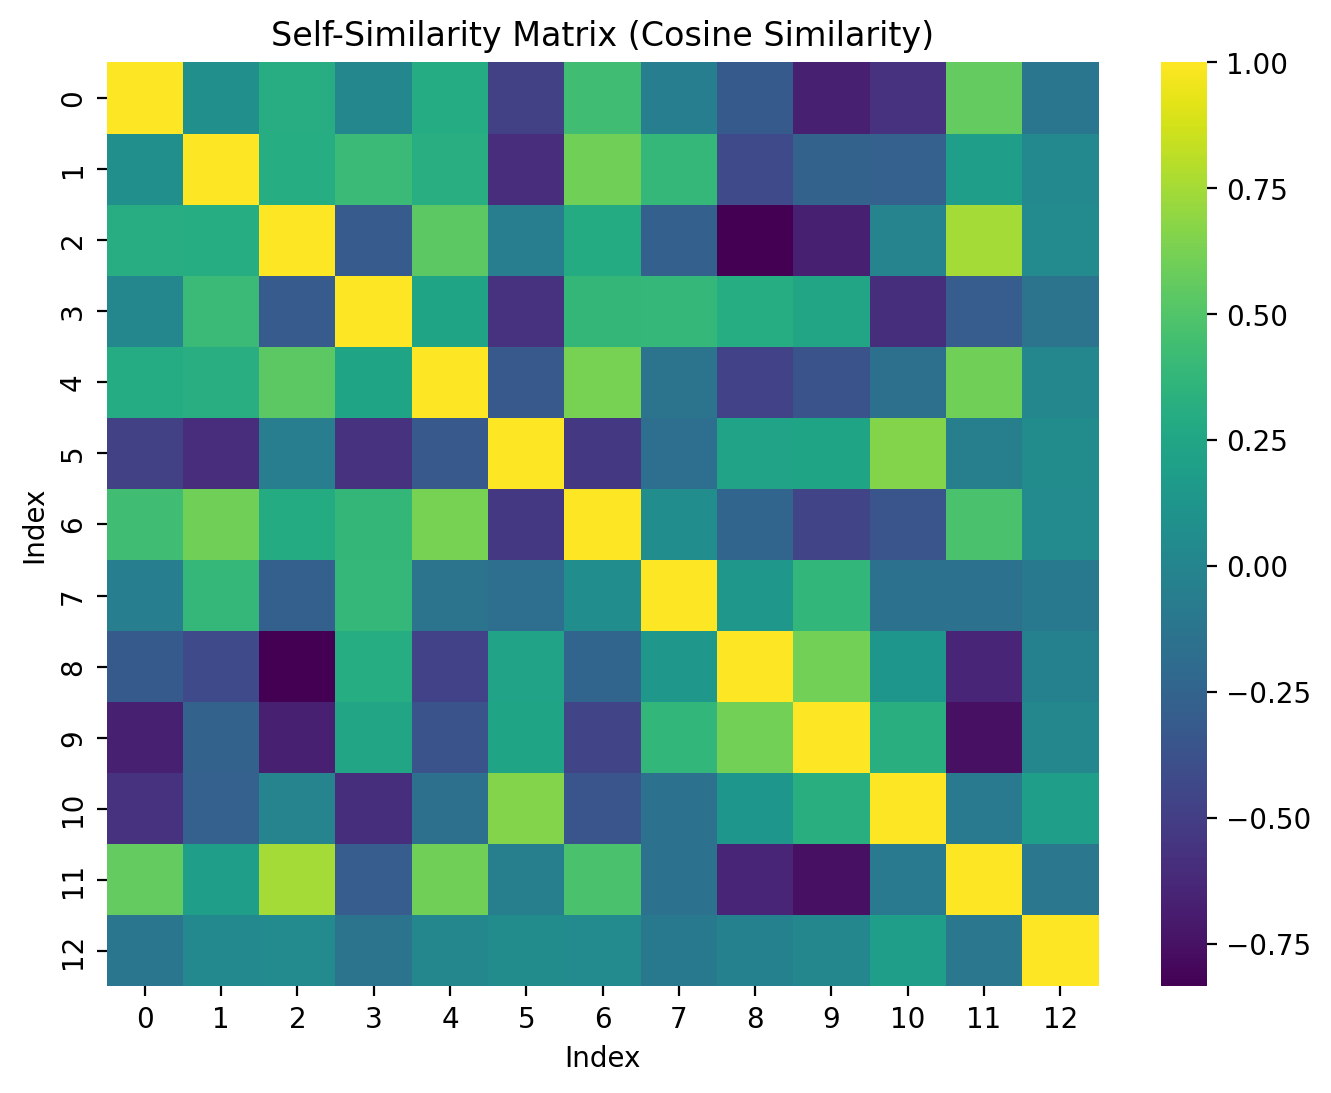

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(sm_4[1].numpy(), cmap='viridis')
plt.title('Self-Similarity Matrix (Cosine Similarity)')
plt.xlabel('Index')
plt.ylabel('Index')
plt.show()

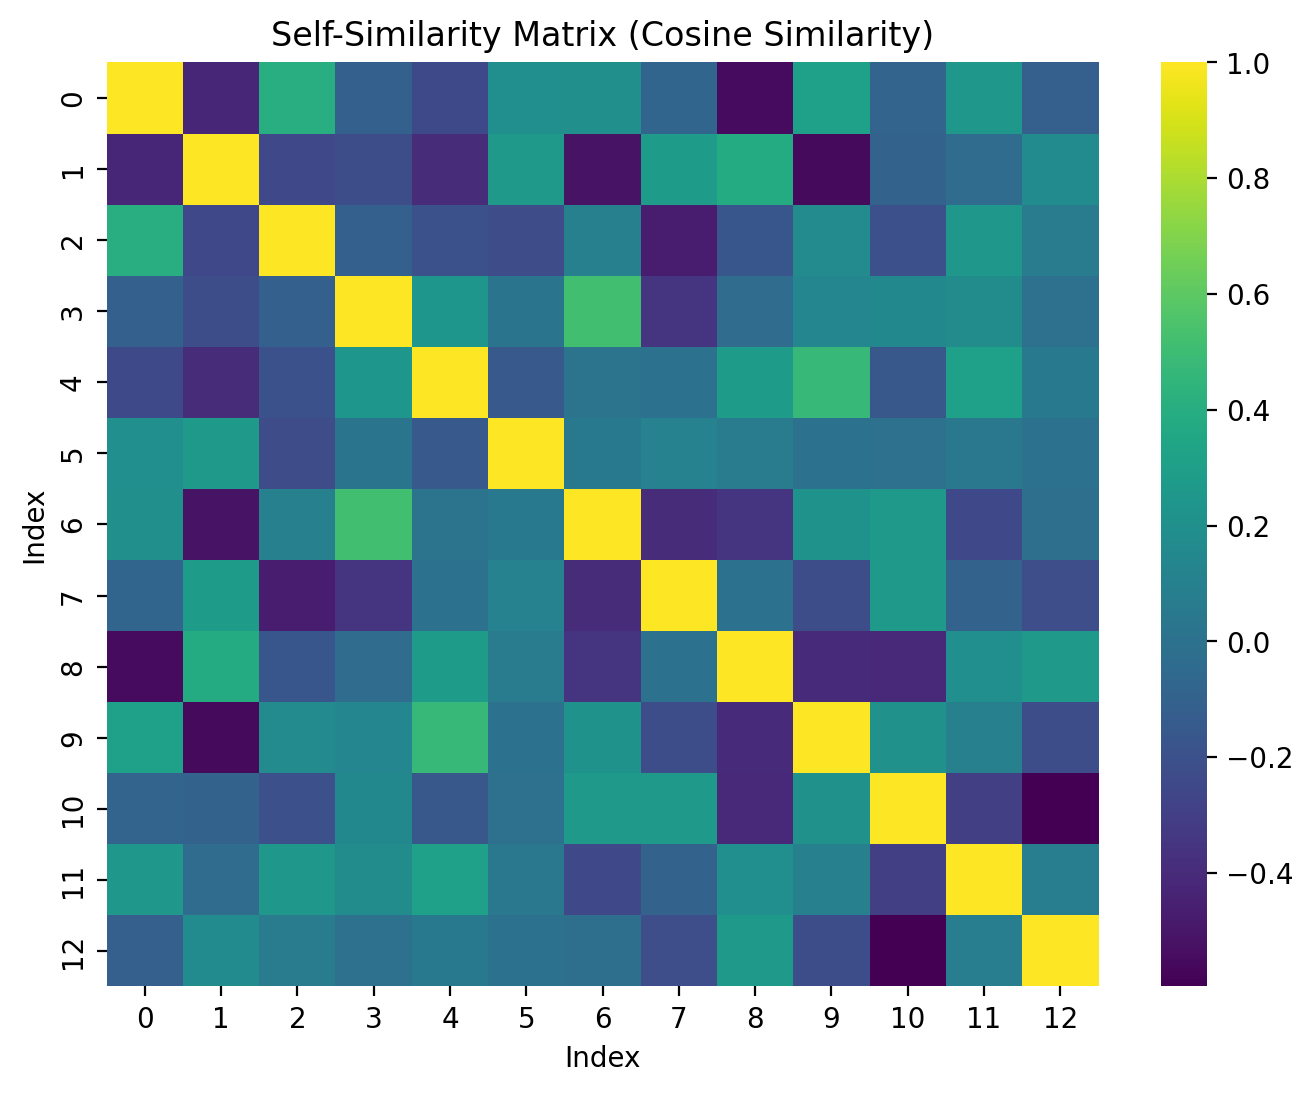

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(sm_4[2].numpy(), cmap='viridis')
plt.title('Self-Similarity Matrix (Cosine Similarity)')
plt.xlabel('Index')
plt.ylabel('Index')
plt.show()

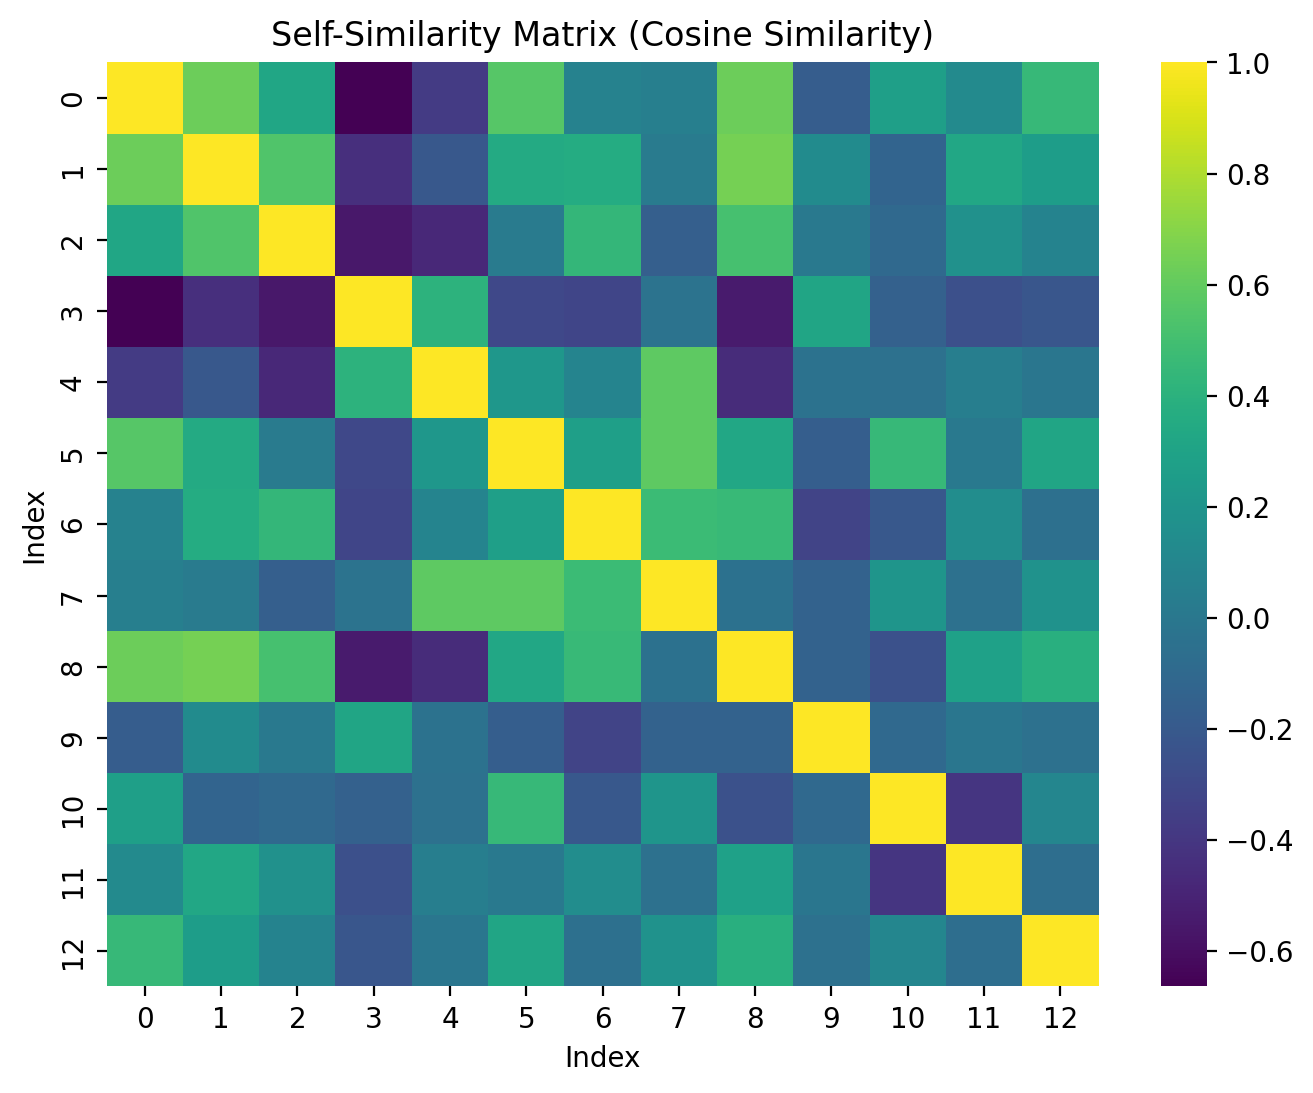

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(sm_4[3].numpy(), cmap='viridis')
plt.title('Self-Similarity Matrix (Cosine Similarity)')
plt.xlabel('Index')
plt.ylabel('Index')
plt.show()